# Initial setting

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [110]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import functools
import pickle

import imblearn
from imblearn.over_sampling import SMOTE

from scipy import stats
from math import pi

from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [111]:
# create a progressbar function
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [112]:
# common parameters for figures
fig_params = {'legend.fontsize': 'large',
              'figure.figsize': (10, 6),
              'axes.labelsize': 'large',
              'axes.titlesize':'x-large',
              'xtick.labelsize':'large',
              'ytick.labelsize':'large'}
pylab.rcParams.update(fig_params)

# Part A

## Data handling

### create the dataset for Part A

In [58]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

# filter 2020 and 5 clubs (this dataframe is going to be test set)
select_clubs = ['FC Barcelona','FC Bayern München','Real Madrid','Paris Saint-Germain','Juventus','Manchester City','Liverpool']
df_a_2020 = df[(df['year'] == 2020) & (df['club'].isin(select_clubs))]

# filter everything from 2019 (this is going to be training set)
df_a_2019 = df[df['year'] == 2019]

# merge two dataframe
df_a = pd.concat([df_a_2019, df_a_2020]).drop(['d_foot_left'], axis=1)
print(df_a_2020.shape, df_a_2019.shape, df_a.shape)

(221, 146) (17770, 146) (17991, 145)


In [59]:
# create dummies for nationality, work rate, foot
df_a_nationality = pd.get_dummies(df_a[['nationality']], prefix='d_nationality')
df_a_workrate = pd.get_dummies(df_a[['work_rate']], prefix='d_workrate')
df_a_foot = pd.get_dummies(df_a[['preferred_foot']], prefix='d_foot')
df_a_club = pd.get_dummies(df_a[['club']], prefix='d_foot')

# concate them into df_a
df_a = pd.concat([df_a, df_a_nationality, df_a_workrate, df_a_foot, df_a_club], axis=1)
df_a.shape

(17991, 995)

In [60]:
df_a.to_csv('data/df_a.csv', index=False)

### drop columns, imputation, and train-test divide

In [61]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','work_rate','body_type','team_position','loaned_from',
            'preferred_foot','joined','contract_valid_until','league_name','main_position','team_jersey_number',
            'club']
df_a_all = df_a.drop(drop_vars, axis=1)

# impute zero values for fieldplayers and goalkeeping ability
# this is because goalkeeping ability is not available for field players and vice versa
impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic','release_clause_eur']
impute_vars = impute_vars + [x for x in df_a_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_a_all[var] = df_a_all[var].fillna(0)
    
# impute mean value for ab_mentality_conposure
# Composure is a Player Attribute in FIFA that determines a player's the state or feeling of being calm and 
# controlling their frustration in matches frustration. (from FIFAplay)
df_a_all['ab_mentality_composure'].fillna(df_a_all['ab_mentality_composure'].mean(), inplace=True)

# select players in the following clubs as test set
df_a_te = df_a_all[df_a_all['year'] == 2020].drop(['year'], axis=1)
df_a_tr = df_a_all[df_a_all['year'] == 2019].drop(['year'], axis=1)
print(df_a_tr.shape, df_a_te.shape)

(17770, 979) (221, 979)


## Regression

In [62]:
# assign X and y
X_tr = df_a_tr.drop(['overall'], axis=1)
X_te = df_a_te.drop(['overall'], axis=1)
y_tr = df_a_tr['overall']
y_te = df_a_te['overall']

# standardization
scaler = StandardScaler().fit(X_tr)
X_tr_stan = scaler.transform(X_tr)
X_te_stan = scaler.transform(X_te)

### Lasso regression

In [63]:
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1, 1e+2]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, 
                            X_tr_stan, 
                            y_tr, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 5/5 Done...

18.675537148703818 0.1


In [64]:
lasso_best = Lasso(alpha=la_best_alpha, max_iter=10000)
lasso_best.fit(X_tr_stan, y_tr)

lasso_tr_pred = lasso_best.predict(X_tr_stan)
lasso_te_pred = lasso_best.predict(X_te_stan)

lasso_mse_tr = mean_squared_error(y_tr, lasso_tr_pred)
lasso_mse_te = mean_squared_error(y_te, lasso_te_pred)
print(lasso_mse_tr, lasso_mse_te)

4.945287764552433 7.987019287381537


In [74]:
# save the model to disk
filename = 'models/partA_lasso_best.sav'
pickle.dump(lasso_best, open(filename, 'wb'))

### Random Forest regression (m=p/3)

In [65]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_tr_stan.shape[1]/3),random_state=81)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_tr_stan, y_tr)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 113.8min finished


In [66]:
# simple Random Forest regression
rf_tr_pred = rf_best_estimator.predict(X_tr_stan)
rf_te_pred = rf_best_estimator.predict(X_te_stan)

rf_mse_tr = mean_squared_error(y_tr, rf_tr_pred)
rf_mse_te = mean_squared_error(y_te, rf_te_pred)
print(rf_mse_tr, rf_mse_te)

0.102711098021617 0.722307640037196


In [75]:
# save the model to disk
filename = 'models/partA_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

### XGBoost

In [67]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_tr_stan, y_tr, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [68]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_tr_stan, y_tr)

100%|█████████████████████████████████████████████| 100/100 [1:12:52<00:00, 43.72s/trial, best loss: 8.928813504932943]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9500000000000001,
             gamma=8.055721302386868e-06, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1.2274661445410096,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=0.28671193975173354, reg_lambda=0.00650933174060852,
             scale_pos_weight=1, subsample=0.7000000000000001,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
xgb_tr_pred = xgb_best.predict(X_tr_stan)
xgb_te_pred = xgb_best.predict(X_te_stan)

xgb_mse_tr = mean_squared_error(y_tr, xgb_tr_pred)
xgb_mse_te = mean_squared_error(y_te, xgb_te_pred)
print(xgb_mse_tr, xgb_mse_te)

0.4516870865917849 0.6840630820922725


In [77]:
# save the model to disk
filename = 'models/partA_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

# Part C

## Data handling

### create the dataset for Part C

In [4]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

# select players in the following clubs as test set
df_c = df[df['d_div1_league']==1]

# extract league and club
df_league_club = df_c.copy()
df_league_club = df_league_club[['league_name','club']].drop_duplicates()
df_league_club['variable'] = 'club_' + df_league_club['club']

# create lead variables for target variables (values in the following year)
target_vars = ['overall','value_eur','skill_moves','d_multiple_position','d_trait_Injury_Prone']
added_vars = []

df_c = df_c.sort_values(['sofifa_id','year'])
for i, target_var in enumerate(target_vars):
    # insert lead variables next to original ones
    col_index = list(df_c.columns).index(target_var) + 1
    next_var = target_var + '_next'
    diff_var = target_var + '_diff'
    df_c.insert(col_index, next_var, df_c.groupby(['sofifa_id'])[target_var].shift(-1))
    
    # calculate change to the following years
    # for value, calculate percentage change as distribution is highly skewed
    if target_var == 'value_eur':
        df_c.insert(col_index + 1, diff_var, np.log(df_c[next_var]) - np.log(df_c[target_var]))
    else:
        df_c.insert(col_index + 1, diff_var, df_c[next_var] - df_c[target_var])
        
    added_vars.append(next_var)
    added_vars.append(diff_var)

# create dummies for club, nationality, 
df_c_dummies = pd.get_dummies(df_c[['nationality','club','work_rate','league_name']])
df_c = pd.concat([df_c, df_c_dummies], axis=1)

C:\Users\ryuic\Anaconda3\envs\cs109a\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### drop columns, imputation

In [5]:
df_c.to_csv('data/df_c.csv', index=False)

In [6]:
# drop unnecessary columns
drop_vars = ['sofifa_id','short_name','dob','nationality','club','wage_eur','preferred_foot','work_rate','body_type',
             'team_position','team_jersey_number','joined','contract_valid_until','league_name','release_clause_eur',
             'loaned_from','main_position','year']
df_c_all = df_c.drop(drop_vars, axis=1)

# impute zero values for fieldplayers and goalkeeping ability
# this is because goalkeeping ability is not available for field players and vice versa
impute_vars = ['ab_pace','ab_shooting','ab_passing','ab_dribbling','ab_defending','ab_physic'] + [x for x in df_c_all.columns if x.startswith('ab_gk')]
for var in impute_vars:
    df_c_all[var] = df_c_all[var].fillna(0)
    
# impute mean value for ab_mentality_conposure
# Composure is a Player Attribute in FIFA that determines a player's the state or feeling of being calm and 
# controlling their frustration in matches frustration. (from FIFAplay)
df_c_all['ab_mentality_composure'].fillna(df_c_all['ab_mentality_composure'].mean(), inplace=True)

# save to csv
df_c_all.to_csv('data/df_c_all.csv', index=False)

## Regression

Basic idea  
- We define a club's ability to increase a player stats and value as the club's performance when we control the player's basic characteristics, e.g. age, reputation, skills, etc. 
- Given this, we regress players' overall score (annual change) on all these characteristics and club dummies, and identify the feature importance of a club dummy as the club's performance when controlling other factors.

### Overall score

#### Filter data, standardization, etc.

In [7]:
# separate a dataset for overall score regression and drop NA
section_target = 'overall'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_ovr = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_ovr = df_c_ovr.drop('value_eur', axis=1)
df_c_ovr = df_c_ovr.dropna()

# save to csv
df_c_ovr.to_csv('data/df_c_ovr.csv', index=False)
df_c_ovr.shape

(10517, 361)

In [8]:
# assign X and y
X = df_c_ovr.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_ovr[section_target + '_diff']

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### LASSO

In [9]:
# grid search
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 4/4 Done...

6.743067001152627 0.01


In [10]:
# refit Lasso using best alpha
la_best = Lasso(alpha=la_best_alpha, max_iter=10000)
la_best.fit(X_stan, y)

# store coefficients into dataframe
df_ovr_la_fi = pd.DataFrame({'variable':X.columns,
                             'ovr_la':la_best.coef_})
df_ovr_la_fi = df_ovr_la_fi[df_ovr_la_fi['variable'].str.startswith('club')]

# save the model to disk
filename = 'models/partC_ovr_la_best.sav'
pickle.dump(la_best, open(filename, 'wb'))

Lasso(alpha=0.01, max_iter=10000)

#### Random Forest (m=p/3)

In [12]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_stan.shape[1]/3),random_state=0)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 26.6min finished


In [13]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_ovr_rf_fi = pd.DataFrame({'variable':clubs,
                             'ovr_rf':rf_fi})

# save the model to disk
filename = 'models/partC_ovr_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [14]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [15]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y)

100%|███████████████████████████████████████████████| 100/100 [15:22<00:00,  9.23s/trial, best loss: 6.667907084114356]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.65,
             gamma=0.06737537763833035, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=8.539019477920405,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=0.16836423523146404, reg_lambda=9.890827461835658,
             scale_pos_weight=1, subsample=0.7000000000000001,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_ovr_xgb_fi = pd.DataFrame({'variable':clubs,
                              'ovr_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_ovr_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Market value

#### Filter data, standardization, etc.

In [17]:
# separate a dataset for market value regression and drop NA
section_target = 'value_eur'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_value = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_value = df_c_value.replace([np.inf, -np.inf], np.nan)
df_c_value = df_c_value.dropna()

# save to csv
df_c_value.to_csv('data/df_c_value.csv', index=False)
df_c_value.shape

(8432, 362)

In [18]:
# assign X and y
X = df_c_value.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_value[section_target + '_diff']

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### LASSO

In [19]:
# grid search
# set parameters
la_alphas = [1e-2, 1e-1, 1, 1e+1]

# create empty lists to store errors
la_tr_err, la_val_err = [],[]

# run regression for each alpha
for i,alpha in enumerate(la_alphas):
    # update progressbar
    progressbar(i, len(la_alphas))
    
    # perform cross-validation on the training data with 10 folds and get the mse_scores
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_validate(lasso, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            return_train_score=True,
                            n_jobs=-1)
    
    #Compute the train and validation MSE
    la_tr_err.append(scores['train_score'].mean() * -1)
    la_val_err.append(scores['test_score'].mean() * -1)

# find the degree that returns the minimum validation error
la_min_val_err = min(la_val_err)
la_best_alpha = la_alphas[la_val_err.index(la_min_val_err)]
print(la_min_val_err, la_best_alpha)

 [==================================================] 4/4 Done...

0.3110163303647024 0.01


In [20]:
# refit Lasso using best alpha
la_best = Lasso(alpha=la_best_alpha, max_iter=10000)
la_best.fit(X_stan, y)

# store coefficients into dataframe
df_value_la_fi = pd.DataFrame({'variable':X.columns,
                               'value_la':la_best.coef_})
df_value_la_fi = df_value_la_fi[df_value_la_fi['variable'].str.startswith('club')]

# save the model to disk
filename = 'models/partC_value_la_best.sav'
pickle.dump(la_best, open(filename, 'wb'))

Lasso(alpha=0.01, max_iter=10000)

#### Random Forest (m=p/3)

In [22]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestRegressor(warm_start=True,max_features=int(X_stan.shape[1]/3),random_state=0)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='neg_mean_squared_error',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed: 21.2min finished


In [23]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_value_rf_fi = pd.DataFrame({'variable':clubs,
                               'value_rf':rf_fi})

# save the model to disk
filename = 'models/partC_value_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [24]:
# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBRegressor(random_state=81,
                       min_child_weight=params['min_child_weight'],
                       max_depth=int(params['max_depth']), 
                       subsample=params['subsample'], 
                       colsample_bytree=params['colsample_bytree'],
                       gamma=params['gamma'], 
                       reg_alpha=params['reg_alpha'], 
                       reg_lambda=params['reg_lambda'])
    scores = cross_validate(xgb, X_stan, y, 
                            cv=5, 
                            scoring='neg_mean_squared_error', 
                            n_jobs=-1)
    return -1 * scores['test_score'].mean()

In [25]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBRegressor(random_state=81,
                        min_child_weight=best_params['min_child_weight'],
                        max_depth=int(best_params['max_depth']), 
                        subsample=best_params['subsample'], 
                        colsample_bytree=best_params['colsample_bytree'],
                        gamma=best_params['gamma'], 
                        reg_alpha=best_params['reg_alpha'], 
                        reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y)

100%|██████████████████████████████████████████████| 100/100 [13:33<00:00,  8.14s/trial, best loss: 0.3183672646921562]


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8500000000000001,
             gamma=0.0023861216083917386, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1.9952861535592965,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=81,
             reg_alpha=5.628704955261183e-07, reg_lambda=9.81298801419108,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [26]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_value_xgb_fi = pd.DataFrame({'variable':clubs,
                                'value_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_value_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Skill move

#### Filter data, standardization, etc.

In [189]:
# separate a dataset for overall score regression and drop NA
section_target = 'skill_moves'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_skill = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_skill = df_c_skill.drop('value_eur', axis=1)
df_c_skill = df_c_skill.dropna()

# replace +- 2 -> +-1
df_c_skill[section_target + '_diff'] = df_c_skill[section_target + '_diff'].replace([2, -2], [1, -1])

# save to csv
df_c_skill.to_csv('data/df_c_skill.csv', index=False)
df_c_skill.shape

(10517, 361)

In [196]:
# assign X and y
X = df_c_skill.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_skill[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 15% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.15)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)
counter_new = y.value_counts().to_dict()

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [9]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.0min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.6min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  3.1min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  3.6min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  4.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  4.6min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  5.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  6.2min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  7.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [13]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_log_fi = pd.DataFrame({'variable':clubs,
                                'skill_log':log_fi})

# save the model to disk
filename = 'models/partC_skill_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [ ]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=0)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

In [ ]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_rf_fi = pd.DataFrame({'variable':clubs,
                               'skill_rf':rf_fi})

# save the model to disk
filename = 'models/partC_skill_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [33]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

In [34]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|████████████████████████████████████████████| 100/100 [1:09:10<00:00, 41.50s/trial, best loss: 0.7569701593244501]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8500000000000001,
              gamma=0.0008689781147585586, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5,
              min_child_weight=2.6450170598830938, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=81,
              reg_alpha=1.9800195961898836e-06, reg_lambda=0.007977151632454351,
              scale_pos_weight=None, subsample=0.7000000000000001,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_skill_xgb_fi = pd.DataFrame({'variable':clubs,
                                'skill_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_skill_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Multiple position

#### Filter data, standardization, etc.

In [7]:
# separate a dataset for overall score regression and drop NA
section_target = 'd_multiple_position'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_util = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_util = df_c_util.drop('value_eur', axis=1)
df_c_util = df_c_util.dropna()

# save to csv
df_c_util.to_csv('data/df_c_util.csv', index=False)
df_c_util.shape

(10517, 361)

In [8]:
# assign X and y
X = df_c_util.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_util[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 20% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.2)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)
counter_new = y.value_counts().to_dict()

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [9]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.0min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.6min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  3.1min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  3.6min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  4.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  4.6min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  5.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  6.2min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  7.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [13]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_util_log_fi = pd.DataFrame({'variable':clubs,
                               'util_log':log_fi})

# save the model to disk
filename = 'models/partC_util_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [ ]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=0)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

In [ ]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_util_rf_fi = pd.DataFrame({'variable':clubs,
                              'util_rf':rf_fi})

# save the model to disk
filename = 'models/partC_util_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [33]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

In [34]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|████████████████████████████████████████████| 100/100 [1:09:10<00:00, 41.50s/trial, best loss: 0.7569701593244501]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8500000000000001,
              gamma=0.0008689781147585586, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5,
              min_child_weight=2.6450170598830938, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=81,
              reg_alpha=1.9800195961898836e-06, reg_lambda=0.007977151632454351,
              scale_pos_weight=None, subsample=0.7000000000000001,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_util_xgb_fi = pd.DataFrame({'variable':clubs,
                               'util_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_util_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

### Injury Proneness

#### Filter data, standardization, etc.

In [39]:
# separate a dataset for overall score regression and drop NA
section_target = 'd_trait_Injury_Prone'
added_vars_temp = [x for x in added_vars if not x == section_target + '_diff']
df_c_injury = df_c_all.copy().drop(added_vars_temp, axis=1)
df_c_injury = df_c_injury.drop('value_eur', axis=1)
df_c_injury = df_c_injury.dropna()

# save to csv
df_c_injury.to_csv('data/df_c_injury.csv', index=False)
df_c_injury.shape

(10517, 361)

In [40]:
# assign X and y
X = df_c_injury.drop([section_target, section_target + '_diff'], axis=1)
y = df_c_injury[section_target + '_diff']

# count # of observations by class
# set the desired # of minority classes (up/down) at 20% of the majority class (stay)
counter = y.value_counts().to_dict()
for key in counter.keys():
    if not key == 0.0:
        counter[key] = int(counter[0.0] * 0.2)

# upsampling using SMOTE. 
oversample = SMOTE(sampling_strategy = counter)
X, y = oversample.fit_resample(X, y)
counter_new = y.value_counts().to_dict()

# standardization
scaler = StandardScaler().fit(X)
X_stan = scaler.transform(X)

#### Logistic Regression

In [9]:
# grid search
# set parameters
Cs = [1e-2, 1e-1, 1, 1e+1]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# use logistic regression cv to find the best model 
log_best = LogisticRegressionCV(Cs=Cs, 
                                cv=cv, 
                                penalty=penalty, 
                                solver=solver,
                                class_weight='balanced',
                                n_jobs=-1,
                                verbose=50)
log_best.fit(X_stan,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.0min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done   3 out of  15 | elapsed:  2.6min remaining: 10.4min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  3.1min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   5 out of  15 | elapsed:  3.6min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  4.5min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   7 out of  15 | elapsed:  4.6min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  4.9min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  5.8min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  6.2min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  7.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10.0], class_weight='balanced', cv=5,
                     n_jobs=-1, penalty='l1', solver='liblinear', verbose=50)

In [13]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

log_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = log_best.predict(X_fi_one).mean()
    pred_zero = log_best.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    log_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_log_fi = pd.DataFrame({'variable':clubs,
                                 'injury_log':log_fi})

# save the model to disk
filename = 'models/partC_injury_log_best.sav'
pickle.dump(log_best, open(filename, 'wb'))

#### Random Forest

In [ ]:
# parameters
rf_trees = list(range(100, 450, 50))
rf_depths = list(range(5, 16, 1))
 
rf_params = {'n_estimators': rf_trees, 
             'max_depth': rf_depths}
 
# grid search
rf = RandomForestClassifier(max_features='auto',class_weight='balanced_subsample',random_state=0)
rf_gs = GridSearchCV(estimator=rf,param_grid=rf_params,scoring='accuracy',verbose=1,n_jobs=-1)
rf_gs.fit(X_stan, y)

# extract best parameters and estimator
rf_best_param = rf_gs.best_params_
rf_best_estimator = rf_gs.best_estimator_

In [ ]:
# select club dummies
clubs = [x for x in X.columns if x.startswith('club')]

# compute feature importance
# for each club, compute the difference of predicted values when the club dummy = 1 and 0
# compute change in response variable for all players
X_fi = pd.DataFrame(data=X_stan,
                    columns=X.columns)

# all club dummies = 0 (Since already standardized, impute the minimum value for each club)
X_clubs_min = X_fi[clubs].min()
X_clubs_max = X_fi[clubs].max()
X_fi_zero = X_fi.copy()
for club in clubs:
    X_fi_zero[clubs] = X_clubs_min[club]

rf_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = rf_best_estimator.predict(X_fi_one).mean()
    pred_zero = rf_best_estimator.predict(X_fi_zero).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    rf_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_rf_fi = pd.DataFrame({'variable':clubs,
                                'injury_rf':rf_fi})

# save the model to disk
filename = 'models/partC_injury_rf_best.sav'
pickle.dump(rf_best_estimator, open(filename, 'wb'))

#### XGBoost

In [33]:
# calculate class weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y),y))
w_array = np.ones(y.shape[0], dtype = 'float')
for i in range(len(y)):
    w_array[i] = class_weights[int(y[i]+1)]

# set parameters
param_space = {'min_child_weight': hp.loguniform('min_child_weight', np.log(1), np.log(10)),
               'max_depth': hp.quniform('max_depth', 3, 9, 1),
               'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
               'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
               'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
               'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(1.0)),
               'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-6), np.log(10.0))}

# define score function
def score(params):
    xgb = XGBClassifier(random_state=81,
                        min_child_weight=params['min_child_weight'],
                        max_depth=int(params['max_depth']), 
                        subsample=params['subsample'], 
                        colsample_bytree=params['colsample_bytree'],
                        gamma=params['gamma'], 
                        reg_alpha=params['reg_alpha'], 
                        reg_lambda=params['reg_lambda'],
                        sample_weight=w_array)
    scores = cross_validate(xgb, 
                            X=X_stan, 
                            y=y, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
    return scores['test_score'].mean()

In [34]:
# run gridsearch and find best parameters
max_evals = 100
trials = Trials()
history = []
rstate = np.random.RandomState(81)
best_params = fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals, rstate=rstate)

# refit with the best parameters
xgb_best = XGBClassifier(random_state=81,
                         min_child_weight=best_params['min_child_weight'],
                         max_depth=int(best_params['max_depth']), 
                         subsample=best_params['subsample'], 
                         colsample_bytree=best_params['colsample_bytree'],
                         gamma=best_params['gamma'], 
                         reg_alpha=best_params['reg_alpha'], 
                         reg_lambda=best_params['reg_lambda'])
xgb_best.fit(X_stan, y, sample_weight=w_array)

100%|████████████████████████████████████████████| 100/100 [1:09:10<00:00, 41.50s/trial, best loss: 0.7569701593244501]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8500000000000001,
              gamma=0.0008689781147585586, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5,
              min_child_weight=2.6450170598830938, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=81,
              reg_alpha=1.9800195961898836e-06, reg_lambda=0.007977151632454351,
              scale_pos_weight=None, subsample=0.7000000000000001,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
# compute feature importance
xgb_fi = []
for club in clubs:
    
    # dummy for the seleted club = 1 (similarly, impute the max value for the club)
    X_fi_one = X_fi_zero.copy()
    X_fi_one[club] = X_clubs_max[club]
    
    # predict for each dataframe, take mean and take difference
    pred_one = xgb_best.predict(X_fi_one.to_numpy()).mean()
    pred_zero = xgb_best.predict(X_fi_zero.to_numpy()).mean()
    pred_diff = pred_one - pred_zero
    
    # append
    xgb_fi.append(pred_diff)

# store coefficients into dataframe
df_injury_xgb_fi = pd.DataFrame({'variable':clubs,
                               'injury_xgb':xgb_fi})

# save the model to disk
filename = 'models/partC_injury_xgb_best.sav'
pickle.dump(xgb_best, open(filename, 'wb'))

## Merge all feature importance

In [71]:
# merge all dataframes
merge_dfs = [df_ovr_la_fi, df_ovr_rf_fi, df_ovr_xgb_fi,
             df_value_la_fi, df_value_rf_fi, df_value_xgb_fi,
             df_skill_la_fi, df_skill_rf_fi, df_skill_xgb_fi,
             df_util_log_fi, df_util_rf_fi, df_util_xgb_fi,
             df_injury_log_fi, df_injury_rf_fi, df_injury_xgb_fi]
df_c_fi = functools.reduce(lambda  left,right: pd.merge(left,right,on=['variable']), merge_dfs)

# rescale all feature importance
targets = ['ovr', 'value', 'skill', 'util', 'injury']
models = ['la', 'log', 'rf', 'xgb']
all_pattern = []
for target in targets:
    for model in models:
        all_pattern.append(target + '_' + model)

rescale_scores = []
for pattern in all_pattern:
    try:
        df_c_fi[pattern + '_rescale'] = MinMaxScaler().fit_transform(df_c_fi[[pattern]]) * 100
        rescale_scores.append(pattern + '_rescale')
    except:
        continue

# mean of each section
for target in targets:
    section_scores = [x for x in rescale_scores if x.startswith(target)]
    df_c_fi[target + '_mean'] = df_c_fi[section_scores].mean(axis=1)

# calculate mean of all scores 
df_c_fi['all_mean'] = df_c_fi[rescale_scores].mean(axis=1)

# merge league name
df_c_fi = df_c_fi.merge(df_league_club, on='variable')
df_c_fi = df_c_fi.sort_values(['league_name','all_mean'], ascending=False)
df_c_fi.to_csv('data/df_c_fi.csv', index=False)

,variable,ovr_la,ovr_rf,ovr_xgb,value_la,value_rf,value_xgb,skill_la,skill_rf,skill_xgb,util_la,util_rf,util_xgb,injury_la,injury_rf,injury_xgb,ovr_la_rescale,ovr_rf_rescale,ovr_xgb_rescale,value_la_rescale,value_rf_rescale,value_xgb_rescale,skill_la_rescale,skill_rf_rescale,skill_xgb_rescale,util_la_rescale,util_rf_rescale,util_xgb_rescale,injury_la_rescale,injury_rf_rescale,injury_xgb_rescale,ovr_mean,value_mean,skill_mean,util_mean,injury_mean,all_mean,league_name,club
76,club_SD Eibar,0.019042,0.015199,0.000000,0.006595,0.009660,0.099771,0.0,0.010391,0.075505,-0.000000,-0.004024,0.000000,0.0,-0.000079,0.0,61.790250,24.009951,42.569124,63.400656,58.932929,77.003780,0.0,68.654821,100.000000,100.000000,66.386140,69.512394,0.0,54.103208,32.654496,42.789775,66.445789,56.218274,78.632845,28.919234,54.601183,Spain Primera Division,SD Eibar
67,club_RCD Espanyol,0.063244,0.157218,0.408159,0.000000,0.006468,0.033632,0.0,0.002411,0.000000,0.000000,0.011317,0.006795,-0.0,-0.001998,0.0,79.706246,54.983483,60.009115,47.745949,56.646203,63.306112,0.0,49.805326,44.181770,100.000000,100.000000,73.844768,0.0,38.343963,32.654496,64.899614,55.899421,31.329032,91.281589,23.666153,53.415162,Spain Primera Division,RCD Espanyol
70,club_Real Madrid,0.055333,0.048552,0.148169,0.008895,0.018871,0.068143,0.0,0.002582,0.014903,-0.000000,-0.007521,-0.020011,0.0,-0.000425,0.0,76.499878,31.284066,48.900144,68.860774,65.529877,70.453387,0.0,50.209603,55.199259,100.000000,58.722243,56.753511,0.0,51.259773,32.654496,52.228030,68.281346,35.136287,71.825251,27.971423,51.088467,Spain Primera Division,Real Madrid
69,club_Real Betis,0.024710,0.055922,0.172555,0.002140,0.012304,0.070932,0.0,0.003188,0.000000,0.000000,0.000450,0.000000,-0.0,-0.001814,0.0,64.087678,32.891463,49.942131,52.826595,60.826080,71.031074,0.0,51.641988,44.181770,100.000000,76.188047,69.512394,0.0,39.853294,32.654496,48.973757,61.561250,31.941253,81.900147,24.169263,49.709134,Spain Primera Division,Real Betis
81,club_Sevilla FC,0.025476,0.055922,0.205011,0.000000,0.023001,0.000000,-0.0,0.000002,0.000000,0.000000,-0.000835,0.000000,-0.0,-0.000158,0.0,64.397854,32.891434,51.328906,47.745949,68.488231,56.340710,0.0,44.116468,44.181770,100.000000,73.372246,69.512394,0.0,53.458054,32.654496,49.539398,57.524963,29.432746,80.961547,28.704183,49.232567,Spain Primera Division,Sevilla FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,club_Brighton & Hove Albion,-0.073050,-0.007629,-0.408723,-0.000000,-0.001372,0.000000,0.0,0.002715,0.017714,-0.000000,-0.023072,-0.032177,0.0,0.001458,0.0,24.463182,19.031131,25.105056,47.745949,51.030969,56.340710,0.0,50.523529,57.277342,100.000000,24.647025,48.996405,0.0,66.725037,32.654496,22.866456,51.705876,35.933624,57.881143,33.126511,40.302722,English Premier League,Brighton & Hove Albion
56,club_Newcastle United,-0.073136,-0.009587,-0.288056,-0.007101,-0.003831,-0.071109,-0.0,-0.001846,-0.021910,0.000000,0.000094,0.000000,-0.0,-0.000391,0.0,24.428359,18.604284,30.260942,30.890788,49.269546,41.613645,0.0,39.751940,27.984315,100.000000,75.408059,69.512394,0.0,51.539508,32.654496,24.431195,40.591326,22.578751,81.640151,28.064668,39.461218,English Premier League,Newcastle United
8,club_Aston Villa,-0.097596,-0.017283,-0.413559,-0.016957,-0.017323,-0.152985,-0.0,0.001375,0.000000,0.000000,-0.000285,0.000000,-0.0,0.000220,0.0,14.514385,16.925695,24.898390,7.495359,39.605456,24.656871,0.0,47.359423,44.181770,100.000000,74.578092,69.512394,0.0,56.562718,32.654496,18.779490,23.919229,30.513731,81.363495,29.739071,36.863003,English Premier League,Aston Villa
19,club_Burnley,0.000000,0.042981,0.209826,0.000000,0.023171,0.027669,-0.0,0.000350,0.000000,-0.005678,-0.030888,-0.109024,0.0,0.000168,0.0,54.072030,30.068994,51.534667,47.745949,68.610370,62.071055,0.0,44.938774,44.181770,0.000000,7.520235,0.000000,0.0,56.127932,32.654496,45.225231,59.475791,29.706848

## Visualization

To do  
- radar chart by league
- radar chart for top 3 vs bottom 3 teams
- distribution for each indicator

### Set up

In [234]:
# read dataset
df_c_viz = pd.read_csv('data/df_c_fi.csv')

# list of 5 indicators
sub_scores = ['Overall score','Market value','Skill moves','Utility','Injury resistance']
sub_scores_label = ['Player overall score','Market\nvalue','Technique','Utility','Injury\nresistance']

# select columns
df_c_viz = df_c_viz[['ovr_mean','value_mean','skill_mean','util_mean','injury_mean','all_mean','league_name','club']]
df_c_viz.columns = sub_scores + ['Total score','league','club']
df_c_viz = df_c_viz.sort_values('Total score', ascending=False)

In [235]:
# create a function for radar chart
def make_radar(df, i, ax, target):
    
    if i + 1 > len(df):
        ax.set_visible(False)

    else:
        # number of variable
        N = len(sub_scores)

        # angle of axises
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        # initiate a radar plot
        ax = plt.subplot(2, 3, i+1, polar=True)

        # rotate so that the first category is placed at top
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], sub_scores_label, color='grey', size=13)

        # draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks([20,40,60,80,100], ['20','40','60','80','100'], color="grey", size=9)
        plt.ylim(0,100)

        # create a list of values for each club
        values=df.loc[i][sub_scores].values.flatten().tolist()    
        values += values[:1] 
        ax.plot(angles, values, color=my_palette(i), linewidth=2, linestyle='solid')
        ax.fill(angles, values, color=my_palette(i), alpha=0.4)

        # Add a title
        plt.title(df[target][i] + f' ({df["Total score"][i]:.1f})', size=14)


### Top 3 vs Bottom 3

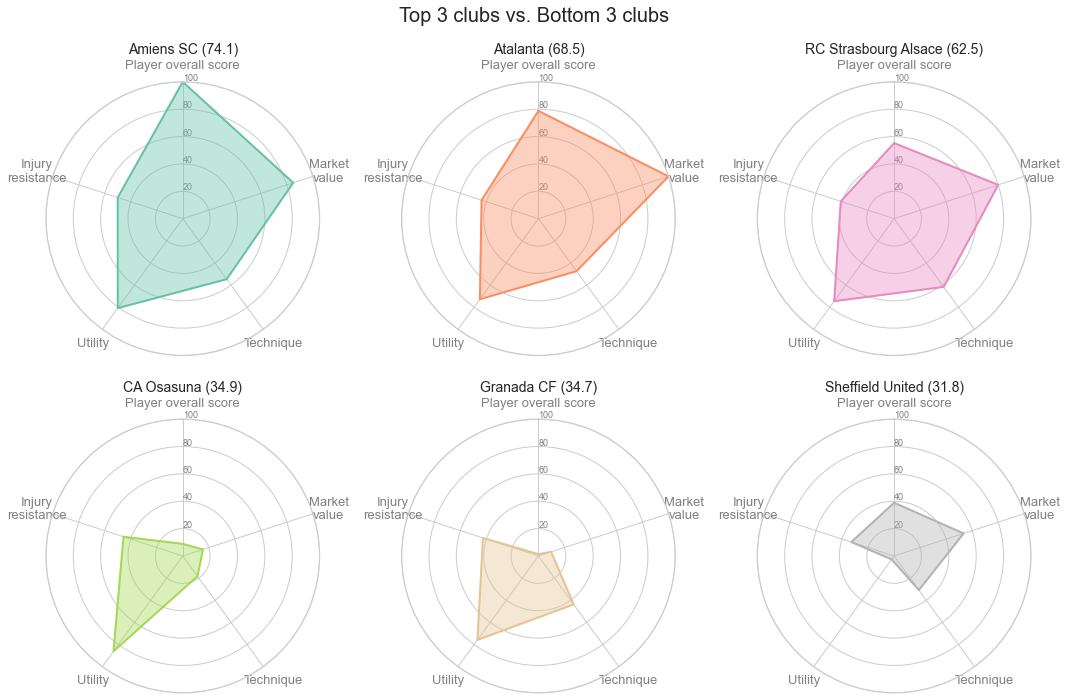

In [238]:
# select top 3 and bottom 3 clubs
df_c_viz_topbottom = pd.concat([df_c_viz.head(3), df_c_viz.tail(3)]).reset_index()

# initialize the figure
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_topbottom.index))
for i, ax in enumerate(axs.ravel()):
    make_radar(df=df_c_viz_topbottom, i=i, ax=ax, target='club')
fig.suptitle('Top 3 clubs vs. Bottom 3 clubs', fontsize=20)
plt.tight_layout()

### League average

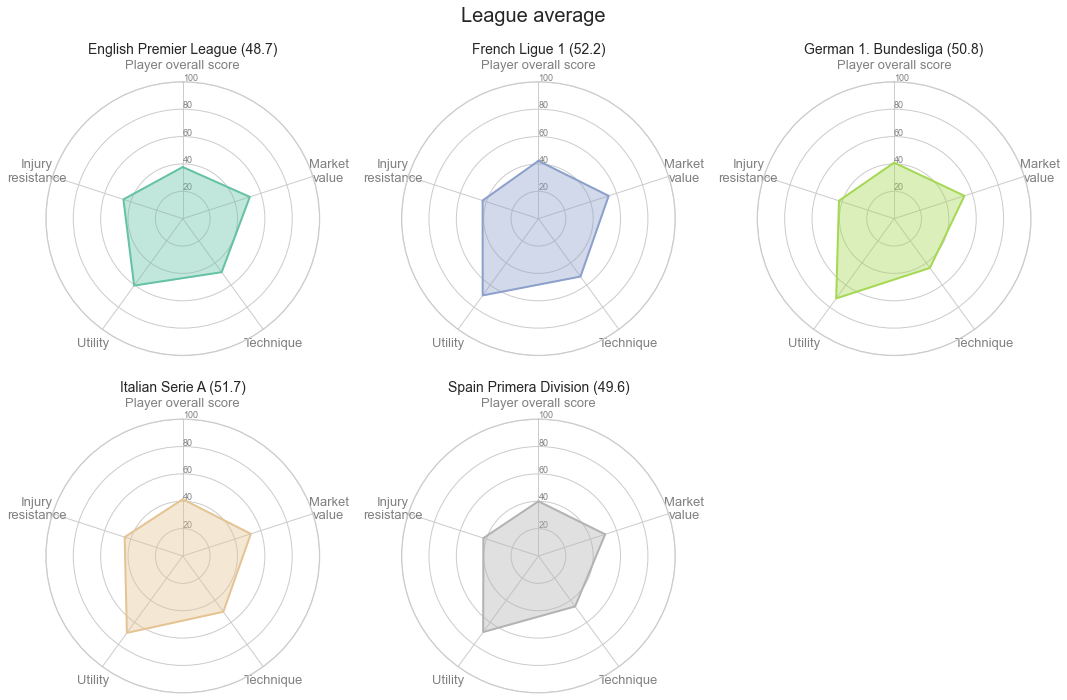

In [239]:
# select top 3 and bottom 3 clubs
df_c_viz_league = df_c_viz.drop(['club'],axis=1).groupby('league', as_index=False).mean()

# initialize the figure
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df_c_viz_league.index))
for i, ax in enumerate(axs.ravel()):
    make_radar(df=df_c_viz_league, i=i, ax=ax, target='league')
fig.suptitle('League average', fontsize=20)
plt.tight_layout()